In [1]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, SpatialDropout1D, Flatten
from tensorflow.keras.optimizers import Adam, SGD, Nadam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import re


In [2]:
remove_words = [
    'I', 'me', 'my', 'mine', 'you', 'your', 'yours', 'he', 'him', 'his', 'she',
    'her', 'hers', 'it', 'its', 'we', 'us', 'our', 'ours', 'they', 'them', 'their', 
    'theirs', 'a', 'an', 'the', 'and', 'but', 'or', 'nor', 'for', 'so', 'yet', 'of', 
    'in', 'to', 'with', 'on', 'at', 'by', 'from', 'about', 'as', 'into', 'like', 'through', 
    'over', 'under', 'between', 'against', 'during', 'before', 'after', 'above', 'below', 
    'since', 'until', 'while', 'where', 'how', 'that', 'which', 'who', 'whom', 'whose','the','is','oh','Oh','ooh','Ooh']

C:\Users\guinu\AppData\Local\Temp\ipykernel_12972\1803822585.py:1: DtypeWarning: Columns (38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,

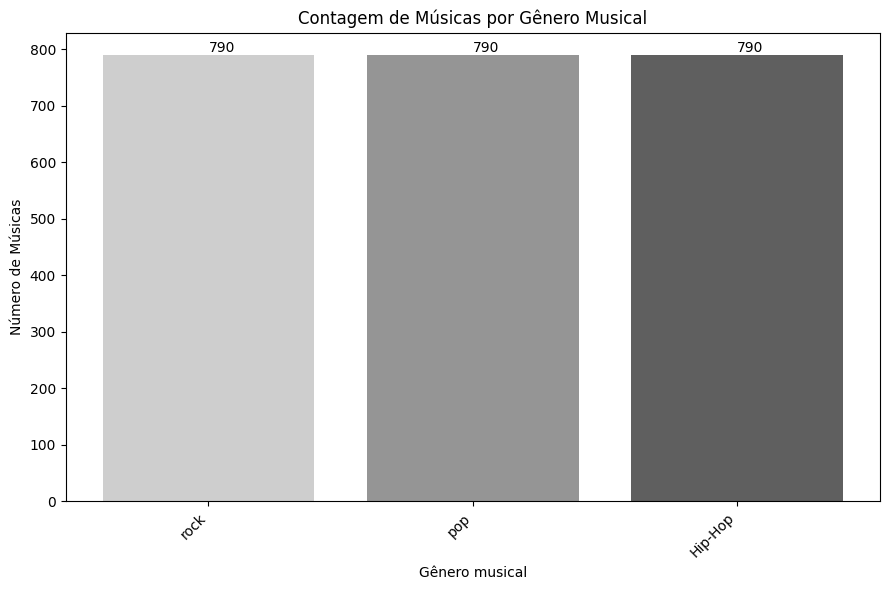

In [26]:
df = pd.read_csv('databases/db.csv', sep=';', header=None)

df = df.drop(columns=df.columns[4:])  # Remove colunas da 5ª em diante
df = df.drop(df.index[:1])  # Remove a primeira linha
df[3] = df[3].str.replace(r'\b(chorus|CHORUS|Pre-Chorus|Chorus|feat|Feat|feat.|Instrumental|intrumental)\b', '', regex=True)
df.columns = ['Music', 'Artist', 'Genra', 'Lyrics']

genre_counts=df['Genra'].value_counts()


plt.figure(figsize=(9, 6))
#colors = plt.cm.tab20.colors  # Obtém uma paleta de 20 cores distintas
colors = plt.cm.Greys(np.linspace(0.3, 0.7, len(genre_counts)))  # Paleta de tons de cinza
# Plotar o gráfico de barras
bars = plt.bar(genre_counts.index, genre_counts.values, color=colors[:len(genre_counts)])

# Adicionar título e rótulos aos eixos
plt.title('Contagem de Músicas por Gênero Musical')
plt.xlabel('Gênero musical')
plt.ylabel('Número de Músicas')

# Adicionar rótulos nas barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment

# Mostrar o gráfico
plt.xticks(rotation=45, ha='right')  # Rotacionar rótulos do eixo x para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar sobreposições
plt.show()

## Processamento de Palavras POP


In [4]:
pop = df[df['Genra'] == 'pop']
pop.head()

,Music,Artist,Genra,Lyrics
791,Chicago,Michael Jackson,pop,"Ah, I met her on my way to Chicago Where she w..."
792,Remember the Time,Michael Jackson,pop,"I don't know, bet you wanna try Every time you..."
793,Beat It,Michael Jackson,pop,"They told him, ""Don't you ever come around her..."
794,Don't Stop 'Til You Get Enough,Michael Jackson,pop,"You know, I was I was wondering, you know If y..."
795,Smooth Criminal -,Michael Jackson,pop,Ow! Cha! Shoo-ca-choo-ca! As he came into th...


In [5]:
pop = pop.copy()
# Divida as letras em listas de palavras
pop['Words'] = pop['Lyrics'].str.split()
# Remova quaisquer valores ausentes
pop.dropna(inplace=True)
# Crie uma nova coluna com o comprimento das listas de palavras
pop['Diferent_words'] = pop['Words'].apply(len)
# Exiba as primeiras linhas do DataFrame
pop.head()


,Music,Artist,Genra,Lyrics,Words,Diferent_words
791,Chicago,Michael Jackson,pop,"Ah, I met her on my way to Chicago Where she w...","[Ah,, I, met, her, on, my, way, to, Chicago, W...",659
792,Remember the Time,Michael Jackson,pop,"I don't know, bet you wanna try Every time you...","[I, don't, know,, bet, you, wanna, try, Every,...",446
793,Beat It,Michael Jackson,pop,"They told him, ""Don't you ever come around her...","[They, told, him,, ""Don't, you, ever, come, ar...",452
794,Don't Stop 'Til You Get Enough,Michael Jackson,pop,"You know, I was I was wondering, you know If y...","[You, know,, I, was, I, was, wondering,, you, ...",713
795,Smooth Criminal -,Michael Jackson,pop,Ow! Cha! Shoo-ca-choo-ca! As he came into th...,"[Ow!, Cha!, Shoo-ca-choo-ca!, As, he, came, in...",574


In [6]:
MAX_WORDS = 2500
MAX_SEQUENCE_LENGTH = 355
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[]^_`{|}~')
tokenizer.fit_on_texts(pop.Lyrics.values)
word_index = tokenizer.word_index
X = tokenizer.texts_to_sequences(pop.Lyrics.values)

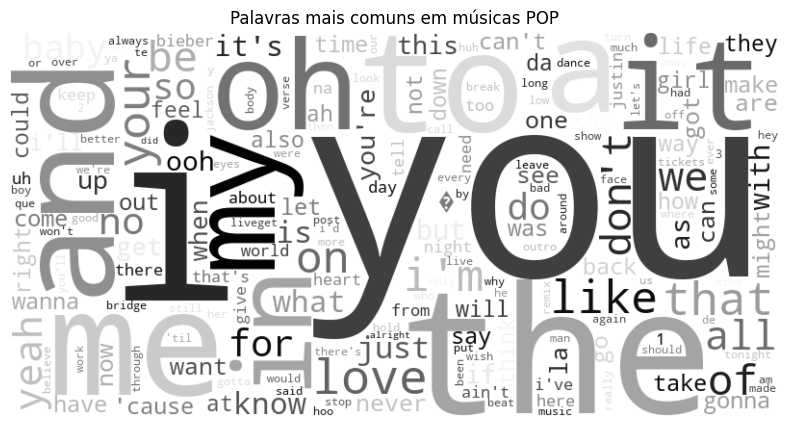

In [27]:
from wordcloud import WordCloud
sequences_pop = tokenizer.texts_to_sequences(pop['Lyrics'].values)

all_words_pop = [word for seq in sequences_pop for word in seq]

# Count the frequency of each word
word_freq = pd.Series(all_words_pop).value_counts()

# Map word indices back to words
reverse_word_index = dict([(index, word) for word, index in word_index.items()])
word_freq = word_freq.rename(index=reverse_word_index)

# Generate word cloud
#wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='gray').generate_from_frequencies(word_freq)
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Palavras mais comuns em músicas POP')
plt.axis('off')
plt.show()

## Processamento de palavras ROCK

In [8]:
rock = df[df['Genra'] == 'rock']

rock = rock.copy()
# Divida as letras em listas de palavras
rock['Words'] = rock['Lyrics'].str.split()
# Remova quaisquer valores ausentes
rock.dropna(inplace=True)
# Crie uma nova coluna com o comprimento das listas de palavras
rock['Diferent_words'] = rock['Words'].apply(len)
X = tokenizer.texts_to_sequences(rock.Lyrics.values)
rock.head()

,Music,Artist,Genra,Lyrics,Words,Diferent_words
1,Enter Sandman,Metallica,rock,"Say your prayers, little one, don't forget, ...","[Say, your, prayers,, little, one,, don't, for...",261
2,Whiskey In The Jar,Metallica,rock,As I was going over the Cork and Kerry mountai...,"[As, I, was, going, over, the, Cork, and, Kerr...",316
3,Master Of Puppets,Metallica,rock,"End of passion play, crumbling away I'm your s...","[End, of, passion, play,, crumbling, away, I'm...",364
4,Fuel,Metallica,rock,"Give me fuel, give me fire Give me that which ...","[Give, me, fuel,, give, me, fire, Give, me, th...",251
5,Nothing Else Matters,Metallica,rock,"[Refrain] So close, no matter how far Couldn'...","[[Refrain], So, close,, no, matter, how, far, ...",245


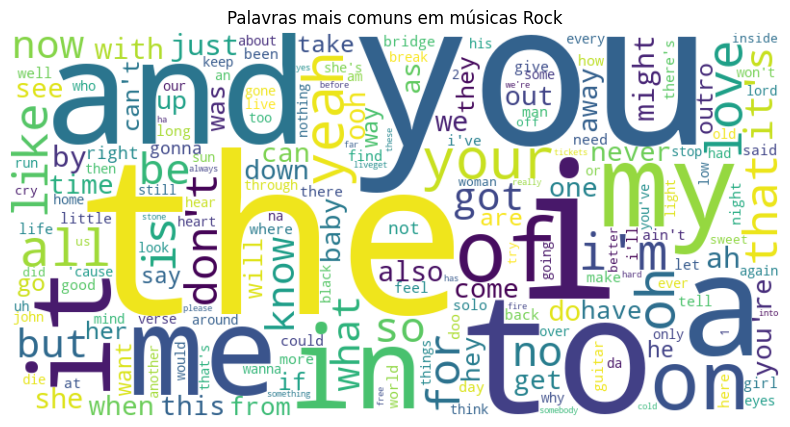

In [9]:
sequences_rock = tokenizer.texts_to_sequences(rock['Lyrics'].values)

all_words_rock = [word for seq in sequences_rock for word in seq]

# Count the frequency of each word
word_freq = pd.Series(all_words_rock).value_counts()

# Map word indices back to words
reverse_word_index = dict([(index, word) for word, index in word_index.items()])
word_freq = word_freq.rename(index=reverse_word_index)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Palavras mais comuns em músicas Rock')
plt.axis('off')
plt.show()

## Processamento de palavras Hip-Hop


In [10]:
hiphop = df[df['Genra'] == 'Hip-Hop']

hiphop = hiphop.copy()
# Divida as letras em listas de palavras
hiphop['Words'] = hiphop['Lyrics'].str.split()
# Remova quaisquer valores ausentes
hiphop.dropna(inplace=True)
# Crie uma nova coluna com o comprimento das listas de palavras
hiphop['Diferent_words'] = hiphop['Words'].apply(len)
X = tokenizer.texts_to_sequences(hiphop.Lyrics.values)
hiphop.head()

,Music,Artist,Genra,Lyrics,Words,Diferent_words
1581,Umbrella,Rihanna,Hip-Hop,"Uh-huh, uh-huh (Yeah, Rihanna) Uh-huh, uh-huh ...","[Uh-huh,, uh-huh, (Yeah,, Rihanna), Uh-huh,, u...",537
1582,Empire State Of Mind,JAY-Z,Hip-Hop,"Yeah [Verse 1: JAY-Z & Alicia Keys] Yeah, I'm...","[Yeah, [Verse, 1:, JAY-Z, &, Alicia, Keys], Ye...",178
1583,Numb / Encore,JAY-Z,Hip-Hop,"Yeah Thank you, thank you, thank you, you're f...","[Yeah, Thank, you,, thank, you,, thank, you,, ...",626
1584,Ni**as In Paris,JAY-Z,Hip-Hop,Rap is a victorious genre. Having built its h...,"[Rap, is, a, victorious, genre., Having, built...",1015
1585,Run This Town,JAY-Z,Hip-Hop,[Intro: Rihanna & Jay Z] Feel it comin' in th...,"[[Intro:, Rihanna, &, Jay, Z], Feel, it, comin...",471


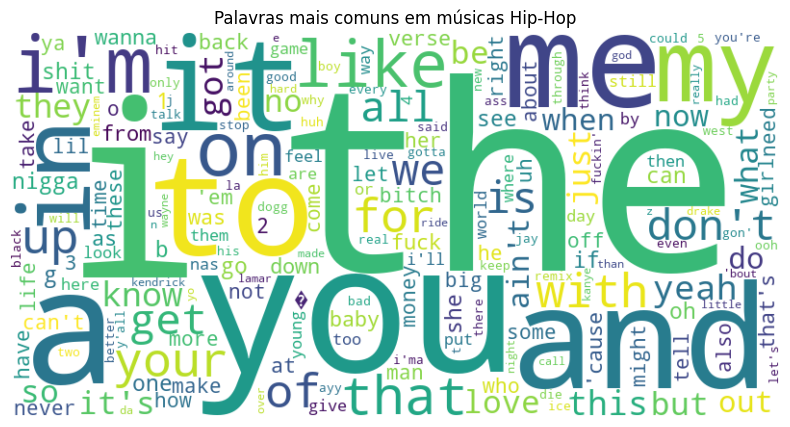

In [11]:
sequences_hiphop = tokenizer.texts_to_sequences(hiphop['Lyrics'].values)

all_words_hiphop = [word for seq in sequences_hiphop for word in seq]

# Count the frequency of each word
word_freq = pd.Series(all_words_hiphop).value_counts()

# Map word indices back to words
reverse_word_index = dict([(index, word) for word, index in word_index.items()])
word_freq = word_freq.rename(index=reverse_word_index)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais comuns em músicas Hip-Hop')
plt.show()

In [12]:
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk


# Exemplo de DataFrames
# pop = pd.read_csv('pop.csv')
# rock = pd.read_csv('rock.csv')
# hiphop = pd.read_csv('hiphop.csv')

# Combine todos os DataFrames em um só
all_genra =df['Genra']
all_genra = df.copy()


all_genra['Words'] = all_genra['Lyrics'].str.split()
# Remova quaisquer valores ausentes
all_genra.dropna(inplace=True)
# Crie uma nova coluna com o comprimento das listas de palavras
all_genra['Diferent_words'] = all_genra['Words'].apply(len)
# Exiba as primeiras linhas do DataFrame
all_genra.head()

,Music,Artist,Genra,Lyrics,Words,Diferent_words
1,Enter Sandman,Metallica,rock,"Say your prayers, little one, don't forget, ...","[Say, your, prayers,, little, one,, don't, for...",261
2,Whiskey In The Jar,Metallica,rock,As I was going over the Cork and Kerry mountai...,"[As, I, was, going, over, the, Cork, and, Kerr...",316
3,Master Of Puppets,Metallica,rock,"End of passion play, crumbling away I'm your s...","[End, of, passion, play,, crumbling, away, I'm...",364
4,Fuel,Metallica,rock,"Give me fuel, give me fire Give me that which ...","[Give, me, fuel,, give, me, fire, Give, me, th...",251
5,Nothing Else Matters,Metallica,rock,"[Refrain] So close, no matter how far Couldn'...","[[Refrain], So, close,, no, matter, how, far, ...",245


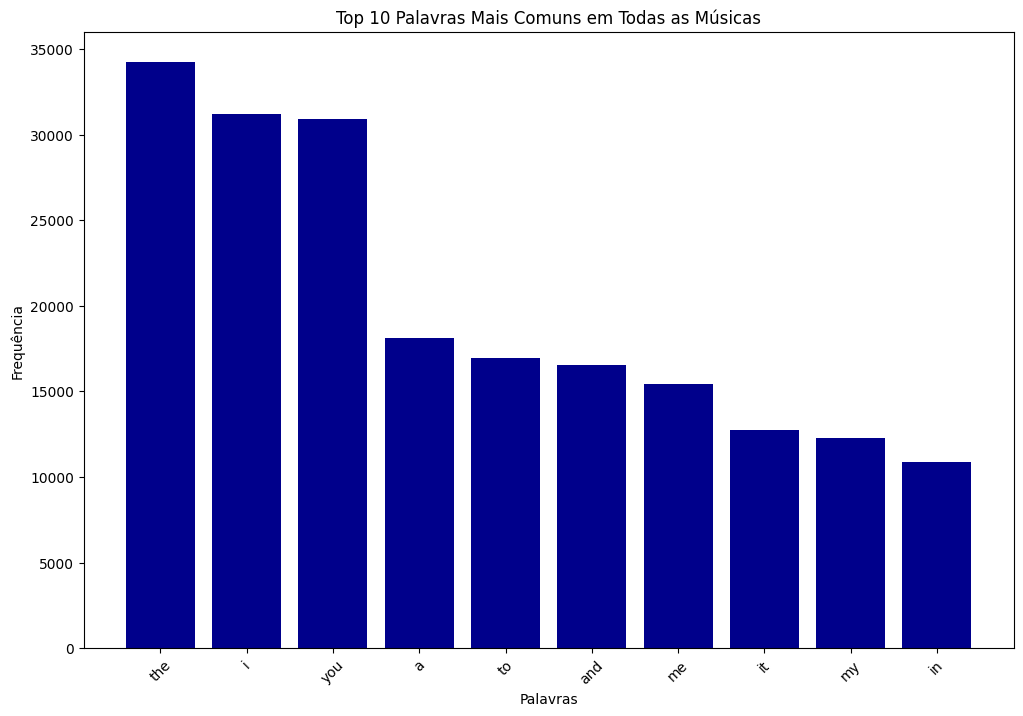

In [13]:
sequences_all_genra = tokenizer.texts_to_sequences(all_genra['Lyrics'].values)
all_words_all_genra = [word for seq in sequences_all_genra for word in seq]

# Count the frequency of each word
word_freq = pd.Series(all_words_all_genra).value_counts()

reverse_word_index = dict([(index, word) for word, index in tokenizer.word_index.items()])
word_freq = word_freq.rename(index=reverse_word_index)

# Obter as 10 palavras mais comuns
top_words = word_freq.head(10)

# Plotar o gráfico de barras
plt.figure(figsize=(12, 8))
plt.bar(top_words.index, top_words.values, color='darkblue')
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.title('Top 10 Palavras Mais Comuns em Todas as Músicas')
plt.xticks(rotation=45)
plt.show()



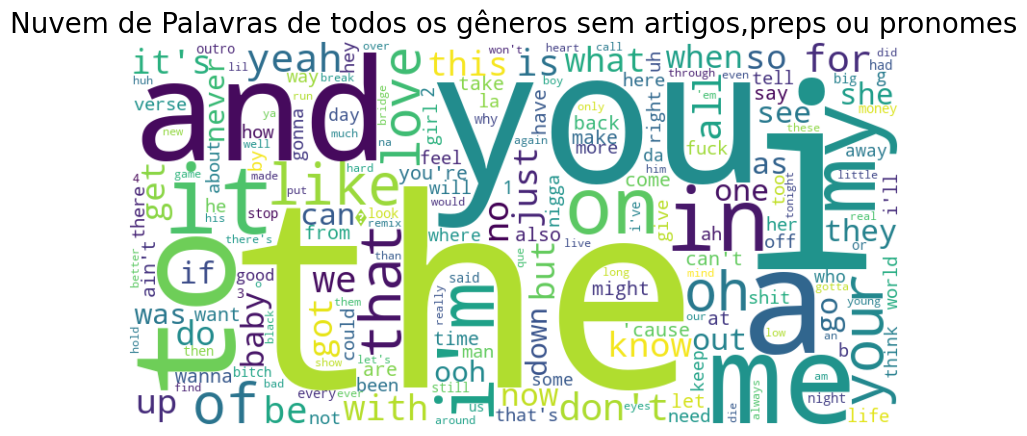

In [14]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Nuvem de Palavras de todos os gêneros sem artigos,preps ou pronomes', fontsize=20)
plt.axis('off')
plt.show()

## Gráficos sem Artigos, Preposições ou pronomes

In [15]:
realRock=rock.copy()


# Construa uma expressão regular para remover as palavras listadas
pattern = r'\b(?:' + '|'.join(re.escape(word) for word in remove_words) + r')\b'

# Remover as palavras da coluna 'Lyrics'
realRock['Lyrics'] = realRock['Lyrics'].str.replace(pattern, '', regex=True, case=False)

# Divida as letras em listas de palavras
realRock['Words'] = realRock['Lyrics'].str.split()

# Remova quaisquer valores ausentes
realRock.dropna(inplace=True)

# Crie uma nova coluna com o comprimento das listas de palavras
realRock['Diferent_words'] = realRock['Words'].apply(len)

# Exiba as primeiras linhas do DataFrame
realRock.head()

,Music,Artist,Genra,Lyrics,Words,Diferent_words
1,Enter Sandman,Metallica,rock,"Say prayers, little one, don't forget, son...","[Say, prayers,, little, one,, don't, forget,, ...",185
2,Whiskey In The Jar,Metallica,rock,was going Cork Kerry mountains saw Capta...,"[was, going, Cork, Kerry, mountains, saw, Capt...",198
3,Master Of Puppets,Metallica,rock,"End passion play, crumbling away 'm source ...","[End, passion, play,, crumbling, away, 'm, sou...",267
4,Fuel,Metallica,rock,"Give fuel, give fire Give desire, ! Ye...","[Give, fuel,, give, fire, Give, desire,, !, Ye...",162
5,Nothing Else Matters,Metallica,rock,"[Refrain] close, no matter far Couldn't be ...","[[Refrain], close,, no, matter, far, Couldn't,...",166


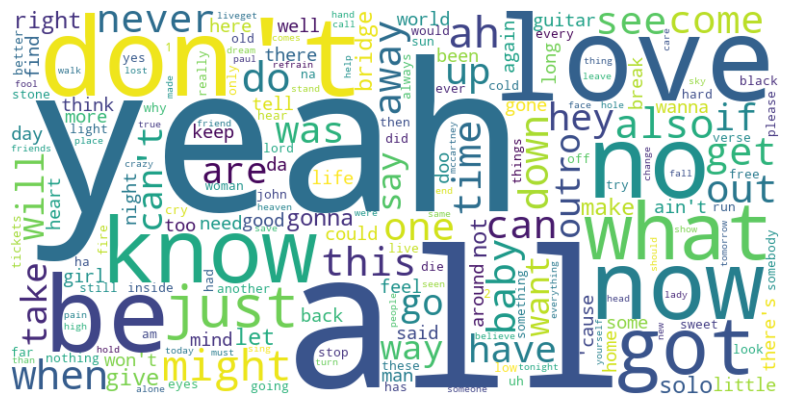

In [31]:
sequences_realRock = tokenizer.texts_to_sequences(realRock['Lyrics'].values)
all_words_realRock = [word for seq in sequences_realRock for word in seq]

# Count the frequency of each word
word_freq = pd.Series(all_words_realRock).value_counts()

reverse_word_index = dict([(index, word) for word, index in tokenizer.word_index.items()])
word_freq = word_freq.rename(index=reverse_word_index)

# Obter as 10 palavras mais comuns


#colorido
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

#tons de cinza
#wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='gray').generate_from_frequencies(word_freq)
#ROCK SEM ARTIGOS, PREPOSICOES OU PRONOMES
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('', fontsize=20)
plt.axis('off')
plt.show()

In [17]:
realPop=pop.copy()

# Construa uma expressão regular para remover as palavras listadas
pattern = r'\b(?:' + '|'.join(re.escape(word) for word in remove_words) + r')\b'

# Remover as palavras da coluna 'Lyrics'
realPop['Lyrics'] = realPop['Lyrics'].str.replace(pattern, '', regex=True, case=False)

# Divida as letras em listas de palavras
realPop['Words'] = realPop['Lyrics'].str.split()

# Remova quaisquer valores ausentes
realPop.dropna(inplace=True)

# Crie uma nova coluna com o comprimento das listas de palavras
realPop['Diferent_words'] = realPop['Words'].apply(len)

# Exiba as primeiras linhas do DataFrame
realPop.head()

,Music,Artist,Genra,Lyrics,Words,Diferent_words
791,Chicago,Michael Jackson,pop,"Ah, met way Chicago was all alone was...","[Ah,, met, way, Chicago, was, all, alone, was,...",418
792,Remember the Time,Michael Jackson,pop,"don't know, bet wanna try Every time see ...","[don't, know,, bet, wanna, try, Every, time, s...",305
793,Beat It,Michael Jackson,pop,"told , ""Don't ever come around here Don't wa...","[told, ,, ""Don't, ever, come, around, here, Do...",335
794,Don't Stop 'Til You Get Enough,Michael Jackson,pop,"know, was was wondering, know If could ke...","[know,, was, was, wondering,, know, If, could,...",506
795,Smooth Criminal -,Michael Jackson,pop,Ow! Cha! Shoo-ca-choo-ca! came window Wa...,"[Ow!, Cha!, Shoo-ca-choo-ca!, came, window, Wa...",402


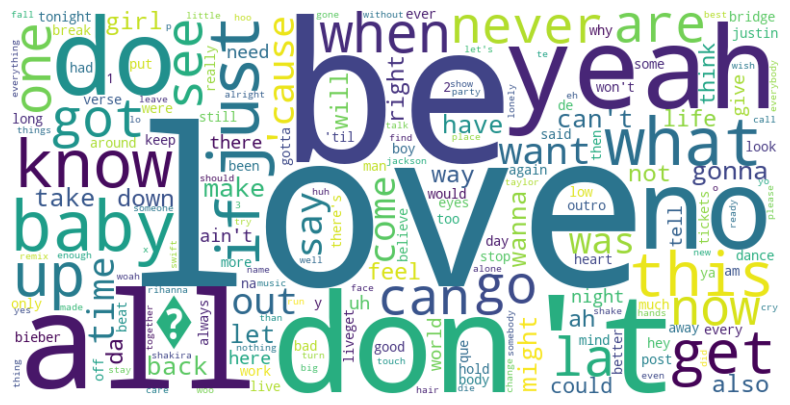

In [32]:
sequences_realPop = tokenizer.texts_to_sequences(realPop['Lyrics'].values)
all_words_realPop = [word for seq in sequences_realPop for word in seq]

# Count the frequency of each word
word_freq = pd.Series(all_words_realPop).value_counts()

reverse_word_index = dict([(index, word) for word, index in tokenizer.word_index.items()])
word_freq = word_freq.rename(index=reverse_word_index)


#Colorido 
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

#tons de cinza
#wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='gray').generate_from_frequencies(word_freq)
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('', fontsize=20)
plt.axis('off')
plt.show()

In [19]:
realHiphop=hiphop.copy()



# Construa uma expressão regular para remover as palavras listadas
pattern = r'\b(?:' + '|'.join(re.escape(word) for word in remove_words) + r')\b'

# Remover as palavras da coluna 'Lyrics'
realHiphop['Lyrics'] = realHiphop['Lyrics'].str.replace(pattern, '', regex=True, case=False)

# Divida as letras em listas de palavras
realHiphop['Words'] = realHiphop['Lyrics'].str.split()

# Remova quaisquer valores ausentes
realHiphop.dropna(inplace=True)

# Crie uma nova coluna com o comprimento das listas de palavras
realHiphop['Diferent_words'] = realHiphop['Words'].apply(len)

# Exiba as primeiras linhas do DataFrame
realHiphop.head()

,Music,Artist,Genra,Lyrics,Words,Diferent_words
1581,Umbrella,Rihanna,Hip-Hop,"Uh-huh, uh-huh (Yeah, Rihanna) Uh-huh, uh-huh ...","[Uh-huh,, uh-huh, (Yeah,, Rihanna), Uh-huh,, u...",399
1582,Empire State Of Mind,JAY-Z,Hip-Hop,"Yeah [Verse 1: JAY-Z & Alicia Keys] Yeah, 'm ...","[Yeah, [Verse, 1:, JAY-Z, &, Alicia, Keys], Ye...",124
1583,Numb / Encore,JAY-Z,Hip-Hop,"Yeah Thank , thank , thank , 're far too kind!...","[Yeah, Thank, ,, thank, ,, thank, ,, 're, far,...",432
1584,Ni**as In Paris,JAY-Z,Hip-Hop,Rap victorious genre. Having built history...,"[Rap, victorious, genre., Having, built, histo...",910
1585,Run This Town,JAY-Z,Hip-Hop,[Intro: Rihanna & Jay Z] Feel comin' air (...,"[[Intro:, Rihanna, &, Jay, Z], Feel, comin', a...",354


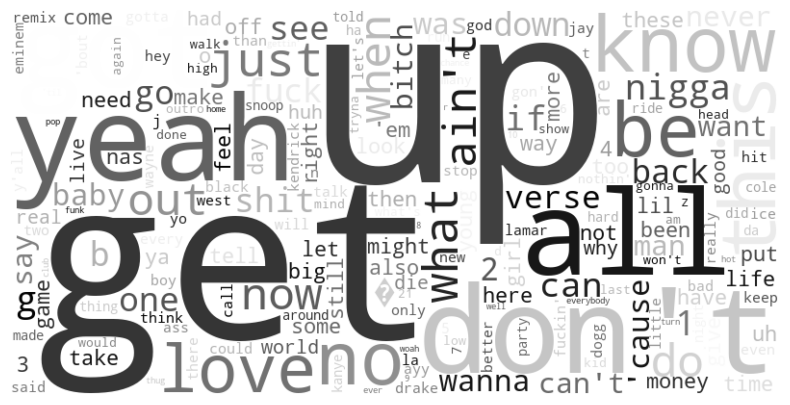

In [30]:
sequences_realHiphop = tokenizer.texts_to_sequences(realHiphop['Lyrics'].values)
all_words_realHiphop = [word for seq in sequences_realHiphop for word in seq]

# Count the frequency of each word
word_freq = pd.Series(all_words_realHiphop).value_counts()

reverse_word_index = dict([(index, word) for word, index in tokenizer.word_index.items()])
word_freq = word_freq.rename(index=reverse_word_index)

# Obter as 10 palavras mais comuns

#Colorido 
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

#tons de cinza
#wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='gray').generate_from_frequencies(word_freq)
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('', fontsize=20)
plt.axis('off')
plt.show()

In [21]:


teste = df.copy()



# Construa uma expressão regular para remover as palavras listadas
pattern = r'\b(?:' + '|'.join(re.escape(word) for word in remove_words) + r')\b'

# Remover as palavras da coluna 'Lyrics'
teste['Lyrics'] = teste['Lyrics'].str.replace(pattern, '', regex=True, case=False)

# Divida as letras em listas de palavras
teste['Words'] = teste['Lyrics'].str.split()

# Remova quaisquer valores ausentes
teste.dropna(inplace=True)

# Crie uma nova coluna com o comprimento das listas de palavras
teste['Diferent_words'] = teste['Words'].apply(len)

# Exiba as primeiras linhas do DataFrame
teste.head()


,Music,Artist,Genra,Lyrics,Words,Diferent_words
1,Enter Sandman,Metallica,rock,"Say prayers, little one, don't forget, son...","[Say, prayers,, little, one,, don't, forget,, ...",185
2,Whiskey In The Jar,Metallica,rock,was going Cork Kerry mountains saw Capta...,"[was, going, Cork, Kerry, mountains, saw, Capt...",198
3,Master Of Puppets,Metallica,rock,"End passion play, crumbling away 'm source ...","[End, passion, play,, crumbling, away, 'm, sou...",267
4,Fuel,Metallica,rock,"Give fuel, give fire Give desire, ! Ye...","[Give, fuel,, give, fire, Give, desire,, !, Ye...",162
5,Nothing Else Matters,Metallica,rock,"[Refrain] close, no matter far Couldn't be ...","[[Refrain], close,, no, matter, far, Couldn't,...",166


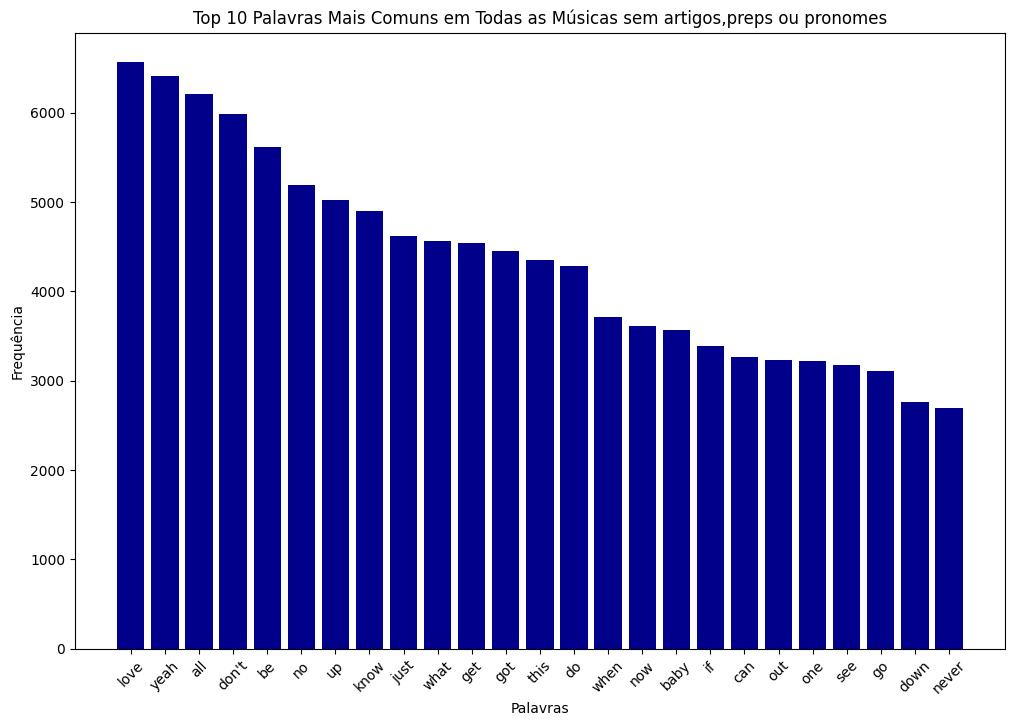

In [22]:
sequences_teste = tokenizer.texts_to_sequences(teste['Lyrics'].values)
all_words_teste = [word for seq in sequences_teste for word in seq]

# Count the frequency of each word
word_freq = pd.Series(all_words_teste).value_counts()

reverse_word_index = dict([(index, word) for word, index in tokenizer.word_index.items()])
word_freq = word_freq.rename(index=reverse_word_index)

# Obter as 10 palavras mais comuns
top_words = word_freq.head(25)

# Plotar o gráfico de barras
plt.figure(figsize=(12, 8))
plt.bar(top_words.index, top_words.values, color='darkblue')
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.title('Top 10 Palavras Mais Comuns em Todas as Músicas sem artigos,preps ou pronomes')
plt.xticks(rotation=45)
plt.show()

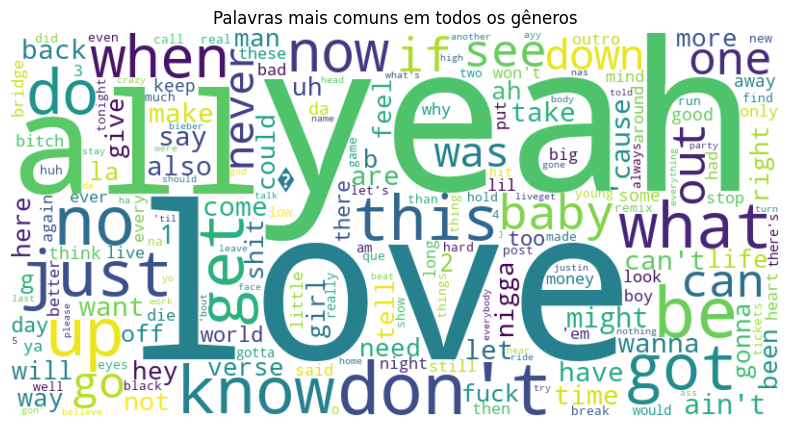

In [23]:

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais comuns em todos os gêneros')
plt.show()